In [42]:
import pytorch_lightning as pl
import torch.utils.data as torch_data
import torch.nn as nn
import pandas as pd
import torch
import sklearn.model_selection as model_selection
from sklearn.preprocessing import StandardScaler
import torch.optim
from pytorch_lightning.loggers import CSVLogger
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import entropy
import sklearn.metrics
import scipy.spatial.distance
import numpy as np
import numpy.linalg
import sklearn.pipeline
import sklearn.multioutput
import sklearn.linear_model

In [75]:
election_data = pd.read_csv("./data/volby/dataset_extended.csv", sep=';')
stratification_cols = ['kraj']
target_cols = [
    'par21spd_ratio', 'par21spolu_ratio', 'par21pirsta_ratio',
    'par21ano_ratio', 'par21soc_ratio', 'par21pri_ratio', 'par21ksc_ratio',
    'par21zel_ratio', 'par21tss_ratio', 'par21other_ratio'
]

education_cols = [
    'sl11vs_ratio', 'sl11vos_ratio', 'sl11nast_ratio', 'sl11strm_ratio',
    'sl11strb_ratio', 'sl11zakl_ratio'
]
election_cols = [
    'par17ano_ratio', 'par17ods_ratio', 'par17top_ratio', 'par17kdu_ratio',
    'par17spd_ratio', 'par17soc_ratio', 'par17pir_ratio', 'par17sta_ratio',
    'par17zel_ratio', 'par17ksc_ratio', 'par17svo_ratio', 'par17other_ratio'
]
other_cols = [
    'sl11muzi_ratio', 'sl11rozv_ratio', 'sl11deti_ratio', 'sl11seni_ratio',
    'sl11kat_ratio', 'sl11rom_ratio'
]
employment_cols = [
    'sl11zam_ratio', 'sl11pod_ratio', 'sl11nezam_ratio', 'sl11neprduch_ratio'
]
datasets = {
    'full': education_cols+election_cols+employment_cols+other_cols,
    'education': education_cols,
    'election': election_cols,
    'employment':employment_cols
}

In [89]:
def evaluate_estimator(estimator_ctor, data, num_folds, feature_cols, target_cols,
             strat_cols, param_dict):
    results =[]
    splitter = model_selection.StratifiedKFold(n_splits=num_folds)
    for train, test in splitter.split(data, data[strat_cols]):
        for params in model_selection.ParameterGrid(param_dict):
            model = sklearn.pipeline.Pipeline([("scaler", StandardScaler()),("model", estimator_ctor(**params))])
            model.fit(data[feature_cols].iloc[train],data[target_cols].iloc[train])
            preds = model.predict(data[feature_cols].iloc[test])
            res = np.linalg.norm(preds-data[target_cols].iloc[test], axis=1, ord=2).mean()
            d = {"score": res } | params
            results = results + [d]
    return results

def evaluate_datasets(data, datasets, target_cols, stratification_cols):
    results = []
    for dataset, cols in datasets.items():
        knn_res = evaluate_estimator(KNeighborsRegressor, data, 10, cols, target_cols, stratification_cols, {'n_neighbors':[x for x in range(3,25)]})
        lin_regr_res = evaluate_estimator(sklearn.linear_model.MultiTaskElasticNet, data, 10, cols, target_cols, stratification_cols, {'l1_ratio':np.linspace(0,1,10),'max_iter':[10000]})

        results+= [{'dataset':dataset, 'method':'knn'} | experiment for experiment in knn_res]
        results+= [{'dataset':dataset, 'method':'lin'} | experiment for experiment in lin_regr_res]

    return results


In [85]:
res = evaluate_datasets(election_data, datasets,target_cols,stratification_cols)

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:2403: UserWarning: Coordinate descent with l1_reg=0 may lead to unexpected results and is discouraged.
  ) = cd_fast.enet_coordinate_descent_multi_task(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:2403: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80.48152740949823, tolerance: 0.029380658094268864
  ) = cd_fast.enet_coordinate_descent_multi_task(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:2403: UserWarning: Coordinate descent with l1_reg=0 may lead to unexpected results and is discouraged.
  ) = cd_fast.enet_coordinate_descent_multi_task(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:2403: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83.51557399307369

In [95]:
results_df = pd.DataFrame(res)
results_df.to_csv("data/volby/modeling_results.csv", index=False)


In [116]:
results_df

,dataset,score,n_neighbors,l1_ratio,max_iter,method
0,full,0.103120,3.0,NaN,NaN,knn
1,full,0.100738,4.0,NaN,NaN,knn
2,full,0.099188,5.0,NaN,NaN,knn
3,full,0.098238,6.0,NaN,NaN,knn
4,full,0.097429,7.0,NaN,NaN,knn
...,...,...,...,...,...,...
1275,employment,0.144401,NaN,0.555556,10000.0,lin
1276,employment,0.144401,NaN,0.666667,10000.0,lin
1277,employment,0.144401,NaN,0.777778,10000.0,lin
1278,employment,0.144401,NaN,0.888889,10000.0,lin


In [105]:
import seaborn.objects as so

In [146]:
results_df_cpy = results_df.copy()
knn_df = results_df_cpy.groupby(['method','dataset','n_neighbors']).agg({'score':'mean'}).reset_index()
lin_df = results_df_cpy.groupby(['method','dataset','l1_ratio']).agg({'score':'mean'}).reset_index()

In [148]:
lin_df.to_csv('data/volby/modeling_results_lin.csv',index = False)
knn_df.to_csv('data/volby/modeling_results_knn.csv',index = False)



In [151]:
import scripts

def _plot_model_perf(df, param_col, label_dict):
    return so.Plot(df, x=param_col, y='score', color='dataset').add(so.Lines(), group='dataset').theme(scripts.object_theme).layout(size=scripts.base_size).label(**label_dict)


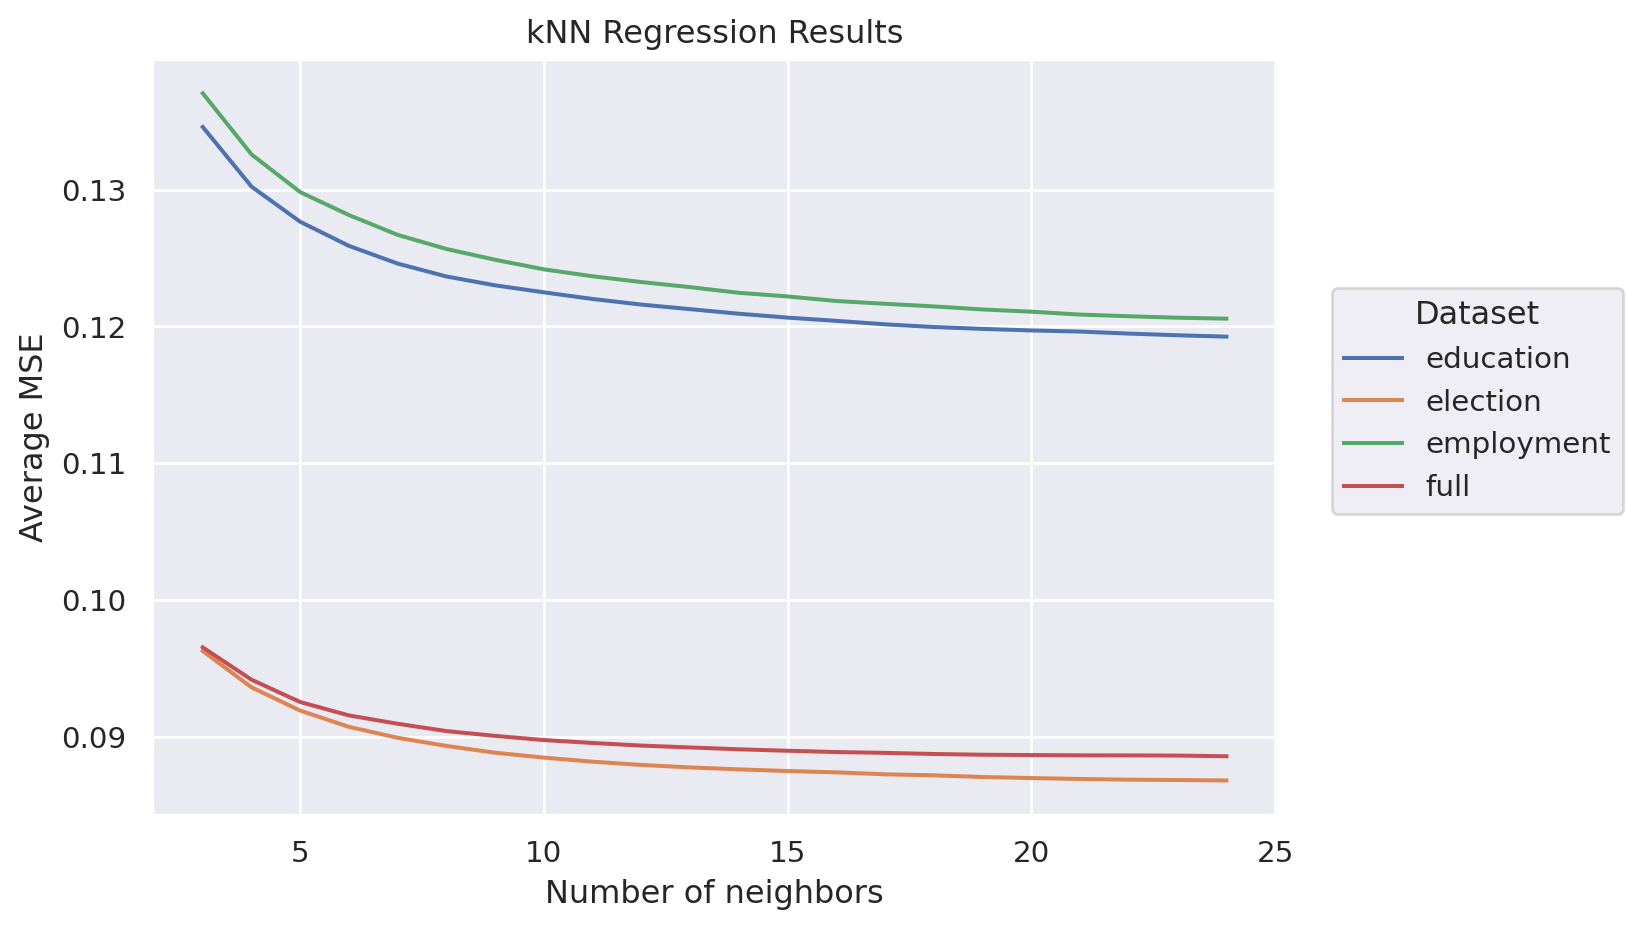

In [153]:
_plot_model_perf(knn_df, 'n_neighbors',{'title':'kNN Regression Results', 'x':'Number of neighbors','y':'Average MSE','color':'Dataset'})

In [ ]:
class PandasDataset(torch_data.Dataset):
    features: pd.DataFrame
    targets: pd.DataFrame

    def __init__(self, features: pd.DataFrame, targets: pd.DataFrame):
        self.features = features
        self.targets = targets

    def __getitem__(self, index):
        x, y =  torch.from_numpy(self.features.iloc[index].to_numpy()).to(torch.float), torch.from_numpy(self.targets.iloc[index].to_numpy()).to(torch.float)
        return x,y

    def __len__(self):
        return len(self.features)


class ElectionDataModule(pl.LightningDataModule):
    batch_size: int

    stratification_columns: list[str]
    feature_columns: list[str]
    target_columns: list[str]

    data_train: PandasDataset
    data_test: PandasDataset
    data_val: PandasDataset

    def __init__(self,stratification_columns: list[str],feature_columns: list[str],target_columns: list[str],batch_size=4):
        super().__init__()
        self.stratification_columns = stratification_columns
        self.target_columns = target_columns
        self.feature_columns = feature_columns
        self.batch_size = batch_size
    
    def prepare_data(self) -> None:
        return super().prepare_data()
        
    def setup(self, stage):
        df = pd.read_csv("./data/volby/dataset_extended.csv", sep=';')

        aux_indices, test_indices = model_selection.train_test_split(df.index, train_size= 3/20, stratify = df[self.stratification_columns])
        train_indices, val_indices = model_selection.train_test_split(aux_indices, train_size= 3/17, stratify=df[self.stratification_columns].iloc[aux_indices])
        scaler = StandardScaler()
        scaler = scaler.fit(df[self.feature_columns].iloc[train_indices])
        scale = lambda x: pd.DataFrame(scaler.transform(x))
        
        self.data_test = PandasDataset(scale(df[self.feature_columns].iloc[train_indices]),df[self.target_columns].iloc[train_indices])
        self.data_train = PandasDataset(scale(df[self.feature_columns].iloc[test_indices]),df[self.target_columns].iloc[test_indices])
        self.data_val = PandasDataset(scale(df[self.feature_columns].iloc[val_indices]),df[self.target_columns].iloc[val_indices])

    def train_dataloader(self):
        return torch_data.DataLoader(self.data_train, batch_size = self.batch_size, num_workers=0)

    def test_dataloader(self):
        return torch_data.DataLoader(self.data_train, batch_size = self.batch_size, num_workers=0)
    
    def val_dataloader(self):
        return torch_data.DataLoader(self.data_val, batch_size=self.batch_size, num_workers=0)

In [ ]:
class SimpleModule(nn.Module):

    def __init__(self, num_features: int):
        super().__init__()
        self.layer = nn.Linear(num_features, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer(x)


class SeparateMultiLogRegression(nn.Module):

    def __init__(self, num_features: int, num_targets: int):
        super().__init__()
        self.regressors = nn.ModuleList([
            SimpleModule(num_features) for _ in range(num_targets)
        ])
        self.softmax = nn.Softmax(dim=0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        xs = torch.cat([reg(x) for reg in self.regressors], dim=1)
        return self.softmax(xs)


class JointMultiLogRegression(nn.Module):

    def __init__(self, num_features: int, num_targets: int, hidden_layer_size: int):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(num_features, hidden_layer_size),
            nn.ReLU(),
            nn.Linear(hidden_layer_size, num_targets), 
            nn.ReLU(),
            nn.Softmax(dim=0)
        )
    def forward(self, x):
        return self.seq(x)



In [ ]:
class ElectionPredictionModule(pl.LightningModule):
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = model
    
    def training_step(self, batch) -> torch.Tensor:
        x, y = batch
        preds = self.model(x)
        loss = nn.functional.kl_div(preds.log(), y,reduction="batchmean")
        self.log("train_loss", loss)
        return loss

    def test_step(self,batch):
        x, y = batch
        preds = self.model(x)
        loss = nn.functional.kl_div(preds.log(), y,reduction="batchmean")
        self.log("test_loss", loss)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self.model(x)
        loss = nn.functional.kl_div(preds.log(), y,reduction="batchmean")
        self.log("val_loss", loss)
        
    def configure_optimizers(self) -> torch.optim.Optimizer:
        optim = torch.optim.Adam(self.parameters())
        return optim
        

In [ ]:

data = ElectionDataModule(
    feature_columns=['sl11vs_ratio', 'sl11vos_ratio', 'sl11nast_ratio', 'sl11strm_ratio','sl11strb_ratio', 'sl11zakl_ratio'],
    target_columns=[ 'par21spd_ratio',
       'par21spolu_ratio', 'par21pirsta_ratio', 'par21ano_ratio', 'par21soc_ratio', 'par21pri_ratio',
       'par21ksc_ratio', 'par21zel_ratio', 'par21tss_ratio','par21other_ratio'],
    stratification_columns=['kraj','vel.obce_cat'], batch_size=128
)
model = ElectionPredictionModule(JointMultiLogRegression(6 ,10, 35))
trainer = pl.Trainer(CSVLogger("logs"), max_epochs=1000, check_val_every_n_epoch=5)
trainer.fit(model, datamodule=data)

In [ ]:
model